In [6]:
from neuralNet import MatrixNeuralNet
from pdes import LinearQuadraticRegulator2D
import matplotlib.pyplot as plt
import numpy as np
import torch
from utils import setLogger

setLogger("training")

In [2]:
layers = [2, 20, 20, 3]
network = MatrixNeuralNet( layers)
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

resu = pde.train(
    interiorPointCount=10,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

2024-08-04 17:01:42,667 - training - INFO - 0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.88e+01 (data: 0.00e+00, grad: 0.00e+00, res: 1.88e+01)
2024-08-04 17:01:45,483 - training - INFO - 1000 / 3000 (0 / 2000), lr:1.0e-03, loss:1.10e-05 (data: 0.00e+00, grad: 0.00e+00, res: 1.10e-05)
2024-08-04 17:01:48,224 - training - INFO - 2000 / 3000 (1000 / 2000), lr:1.0e-03, loss:1.37e-05 (data: 0.00e+00, grad: 0.00e+00, res: 1.37e-05)


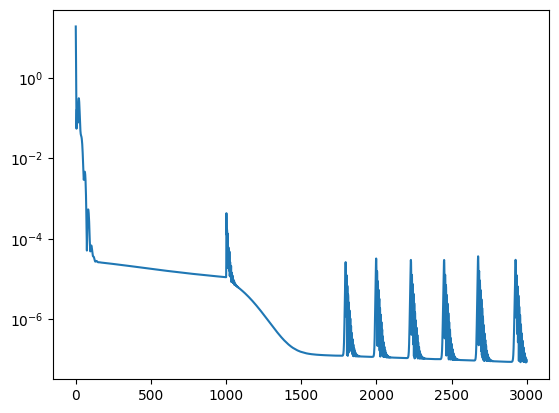

In [3]:
ax = resu['loss'].plot()
ax.set_yscale("log")

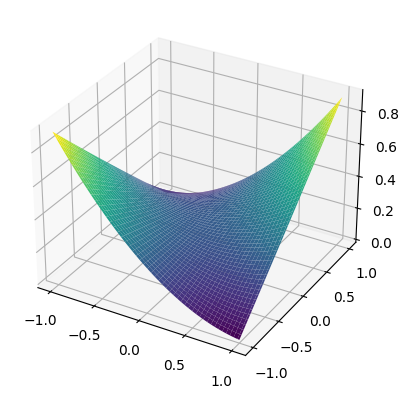

In [4]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

# Convex network

In [7]:
class ConvexInitialiser:
    """
    Initialisation method for input-convex networks.

    Parameters
    ----------
    var : float, optional
        The target variance fixed point.
        Should be a positive number.
    corr : float, optional
        The target correlation fixed point.
        Should be a value between -1 and 1, but typically positive.
    bias_noise : float, optional
        The fraction of variance to originate from the bias parameters.
        Should be a value between 0 and 1
    alpha : float, optional
        Scaling parameter for leaky ReLU.
        Should be a positive number.

    Examples
    --------
    Default initialisation

    >>> icnn = torch.nn.Sequential(
    ...     torch.nn.Linear(200, 400),
    ...     torch.nn.ReLU(),
    ...     ConvexLinear(400, 300),
    ... )
    >>> torch.nn.init.kaiming_uniform_(icnn[0].weight, nonlinearity="linear")
    >>> torch.nn.init.zeros_(icnn[0].bias)
    >>> convex_init = ConvexInitialiser()
    >>> w1, b1 = icnn[1].parameters()
    >>> convex_init(w1, b1)
    >>> assert torch.all(w1 >= 0) and torch.isclose(b1.var(), torch.zeros(1))

    Initialisation with random bias parameters

    >>> convex_bias_init = ConvexInitialiser(bias_noise=0.5)
    >>> convex_bias_init(w1, b1)
    >>> assert torch.all(w1 >= 0) and b1.var() > 0
    """

    @staticmethod
    @torch.no_grad()
    def init_log_normal_(weight: torch.Tensor, mean_sq: float, var: float) -> torch.Tensor:
        """
        Initialise weights with samples from a log-normal distribution.

        Parameters
        ----------
        weight : torch.Tensor
            The parameter to be initialised.
        mean_sq : float
            The squared mean of the normal distribution underlying the log-normal.
        var : float
            The variance of the normal distribution underlying the log-normal.

        Returns
        -------
        weight : torch.Tensor
            A reference to the inputs that have been modified in-place.
        """
        log_mom2 = math.log(mean_sq + var)
        log_mean = math.log(mean_sq) - log_mom2 / 2.
        log_var = log_mom2 - math.log(mean_sq)
        return torch.nn.init.normal_(weight, log_mean, log_var ** .5).exp_()

    def __init__(self, var: float = 1., corr: float = 0.5,
                 bias_noise: float = 0., alpha: float = 0.):
        self.target_var = var
        self.target_corr = corr
        self.bias_noise = bias_noise
        self.relu_scale = 2. / (1. + alpha ** 2)

    def __call__(self, weight: torch.Tensor, bias: torch.Tensor):
        if bias is None:
            raise ValueError("Principled Initialisation for ICNNs requires bias parameter")

        fan_in = torch.nn.init._calculate_correct_fan(weight, "fan_in")
        weight_dist, bias_dist = self.compute_parameters(fan_in)
        weight_mean_sq, weight_var = weight_dist
        self.init_log_normal_(weight, weight_mean_sq, weight_var)

        bias_mean, bias_var = bias_dist
        torch.nn.init.normal_(bias, bias_mean, bias_var ** .5)

    def compute_parameters(self, fan_in: int) -> tuple[
        tuple[float, float], tuple[float, float] | None
    ]:
        """
        Compute the distribution parameters for the initialisation.

        Parameters
        ----------
        fan_in : int
            Number of incoming connections.

        Returns
        -------
        (weight_mean_sq, weight_var) : tuple of 2 float
            The squared mean and variance for weight parameters.
        (bias_mean, bias_var): tuple of 2 float, optional
            The mean and variance for the bias parameters.
            If `no_bias` is `True`, `None` is returned instead.
        """
        target_mean_sq = self.target_corr / self.corr_func(fan_in)
        target_variance = self.relu_scale * (1. - self.target_corr) / fan_in

        shift = fan_in * (target_mean_sq * self.target_var / (2 * math.pi)) ** .5
        bias_var = 0.
        if self.bias_noise > 0.:
            target_variance *= (1 - self.bias_noise)
            bias_var = self.bias_noise * (1. - self.target_corr) * self.target_var

        return (target_mean_sq, target_variance), (-shift, bias_var)

    def corr_func(self, fan_in: int) -> float:
        """ Helper function for correlation (cf. $f_\mathrm{c}$, eq. 35). """
        rho = self.target_corr
        mix_mom = (1 - rho ** 2) ** .5 + rho * math.acos(-rho)
        return fan_in * (math.pi - fan_in + (fan_in - 1) * mix_mom) / (2 * math.pi)


In [8]:
from abc import ABC, abstractmethod
import copy

import torch
from torch import nn

class TraditionalInitialiser:
    """
    Initialisation for regular networks using variance scaling.
    """

    def __init__(self, gain: float = 1.):
        self.gain = gain

    def __call__(self, weight: torch.Tensor, bias: torch.Tensor):
        fan_in = torch.nn.init._calculate_correct_fan(weight, "fan_in")
        weight_dist, bias_dist = self.compute_parameters(fan_in, bias is None)
        weight_mean_sq, weight_var = weight_dist
        torch.nn.init.normal_(weight, weight_mean_sq ** .5, weight_var ** .5)
        if bias is not None:
            bias_mean, bias_var = bias_dist
            torch.nn.init.normal_(bias, bias_mean, bias_var ** .5)

    def compute_parameters(self, fan_in: int, no_bias: bool = False) -> tuple[
        tuple[float, float], tuple[float, float] | None
    ]:
        return (0., self.gain / fan_in), (0., 0.)

class Positivity(ABC):
    """ Interface for function that makes weights positive. """

    @abstractmethod
    def __call__(self, weight: torch.Tensor) -> torch.Tensor:
        """ Transform raw weight to positive weight. """
        ...

    def inverse_transform(self, pos_weight: torch.Tensor) -> torch.Tensor:
        """ Transform positive weight to raw weight before transform. """
        return self.__call__(pos_weight)

class LazyClippedPositivity(Positivity):
    """
    Make weights positive by clipping negative weights after each update.

    References
    ----------
    Amos et al. (2017)
        Input-Convex Neural Networks.
    """

    def __call__(self, weight):
        with torch.no_grad():
            weight.clamp_(0)

        return weight

class ExponentialPositivity(Positivity):
    """
    Make weights positive by applying exponential function during forward pass.
    """

    def __call__(self, weight):
        return torch.exp(weight)

    def inverse_transform(self, pos_weight):
        return torch.log(pos_weight)


class ConvexLinear(nn.Linear):
    """Linear layer with positive weights."""

    def __init__(self, *args, positivity: Positivity = None, **kwargs):
        if positivity is None:
            raise TypeError("positivity must be given as kwarg for convex layer")

        self.positivity = positivity
        super().__init__(*args, **kwargs)

    def forward(self, x):
        return torch.nn.functional.linear(x, self.positivity(self.weight), self.bias)


In [9]:
def get_model(name: str, num_hidden: int = 128, bad_init: bool = False, skip: bool = False):
    num_in, num_out = 2, 1
    if name == "logreg":
        return nn.Linear(num_in, num_out)

    if name == "fc":
        positivity = NoPositivity()
    elif name == "convex":
        positivity = ExponentialPositivity()
    elif name == "icnn":
        positivity = LazyClippedPositivity()
    else:
        raise ValueError(f"unknown model name: {name}")

    model = nn.Sequential(
        nn.Dropout(p=.7),
        nn.Linear(num_in, num_hidden),
        nn.ReLU(),
        nn.Dropout(p=.5),
        ConvexLinear(num_hidden, num_hidden, positivity=positivity),
        nn.ReLU(),
        nn.Dropout(p=.5),
        ConvexLinear(num_hidden, num_out, positivity=positivity),
    )

    init = TraditionalInitialiser(gain=2.) if name == "fc" or bad_init else ConvexInitialiser()
    for idx in [4, 7]:
        init(model[idx].weight, model[idx].bias)

    if skip:
        new_model = LinearSkip(num_in, num_hidden, model[1:5])
        new_model = LinearSkip(num_in, num_out, nn.Sequential(new_model, *model[5:]))
        model = nn.Sequential(model[0], new_model)

    return model

In [10]:
model = get_model("icnn", bad_init=True)

In [11]:
print(model)

Sequential(
  (0): Dropout(p=0.7, inplace=False)
  (1): Linear(in_features=2, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): ConvexLinear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): ConvexLinear(in_features=128, out_features=1, bias=True)
)


In [12]:
model(torch.randn(10, 2))

tensor([[11.7927],
        [ 9.9136],
        [ 7.2320],
        [32.5855],
        [36.9111],
        [ 6.8182],
        [10.5995],
        [44.6478],
        [ 6.3890],
        [14.6329]], grad_fn=<AddmmBackward0>)

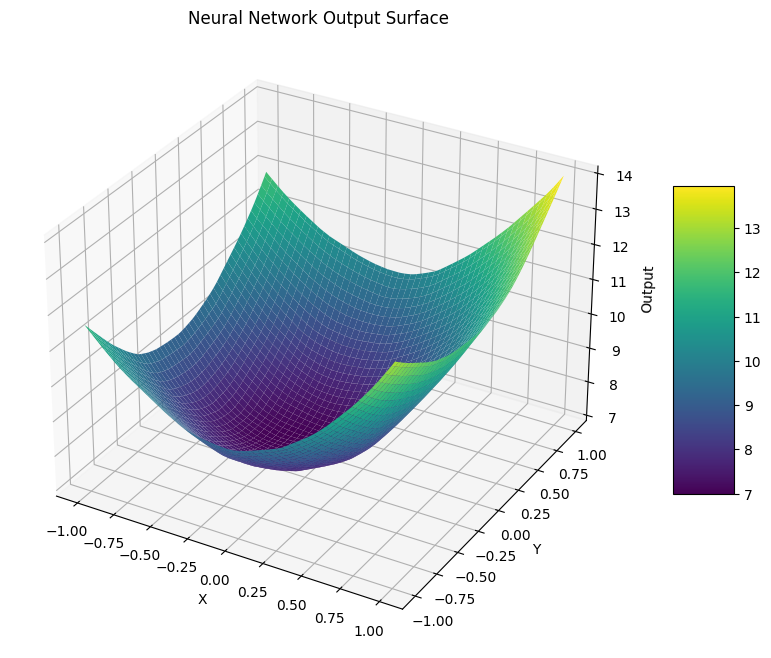

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

# Assuming you have a trained PyTorch model called 'model'
# that takes 2D input and produces 1D output

# Create the input grid
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

# Prepare the input for the model
grid = np.column_stack((X.ravel(), Y.ravel()))

# Convert to PyTorch tensor
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Get predictions from the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    Z = model(grid_tensor)

# Convert back to numpy for plotting
Z = Z.numpy().reshape(X.shape)

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add a color bar
fig.colorbar(surface, shrink=0.5, aspect=5)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Output')
ax.set_title('Neural Network Output Surface')

plt.show()